In [24]:
### LOAD PACKAGES ###
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import kruskal,chisquare
import altair as alt
import ugtm
import textwrap
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy 
from scipy.cluster.hierarchy import dendrogram, linkage
import os
from tqdm.notebook import trange, tqdm
from tqdm.auto import tqdm
from itertools import chain
%matplotlib inline


In [25]:
import warnings

# 忽略所有 SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

In [26]:
def get_fields(fields, data, data_field):
    f = data_field[data_field["field.showcase"].isin(fields) & data_field["field.tab"].str.contains("f\\.\\d+\\.0\\.\\d")].copy()
    f["field"] = pd.Categorical(f["field.showcase"], categories=fields, ordered=True)
    f = f.sort_values("field").reset_index().drop("field", axis=1)
    return f

def get_fields_all(fields, data, data_field):
    f = data_field[data_field["field.showcase"].isin(fields)].copy()
    f["field"] = pd.Categorical(f["field.showcase"], categories=fields, ordered=True)
    f = f.sort_values("field").reset_index().drop("field", axis=1)
    return f

def get_data_fields(fields, data, data_field):
    f = get_fields(fields, data, data_field)
    return data[["eid"]+f["col.name"].to_list()].copy()

def get_data_fields_all(fields, data, data_field):
    f = get_fields_all(fields, data, data_field)
    return data[["eid"]+f["col.name"].to_list()].copy()

In [27]:
def map_column_to_meaning(df, column_name, data_path, file):
    # 读取数据文件
    coding1001 = pd.read_csv(f"{data_path}/{file}", sep="\t")
    
    # 将 coding 列转换为字符串类型
    coding1001['coding'] = coding1001['coding'].astype('str')
    
    # 将列重命名为指定的 column_name
    coding1001.rename(columns={"coding": column_name}, inplace=True)
    
    # 将 column_name 列转换为字符串类型
    df[column_name] = df[column_name].astype('str')
    
    # 创建 code 到 meaning 的映射字典
    code_to_meaning = dict(zip(coding1001[column_name], coding1001['meaning']))
    
    # 使用映射字典替换 column_name 列的值，并将其转换为分类类型
    df[column_name] = df[column_name].map(code_to_meaning).astype('category')

In [29]:
from datetime import datetime, timedelta

def datetime_from_dec_year(dec_year):
    start = dec_year
    year = int(start)
    rem = start - year

    base = datetime(year, 1, 1)
    result = base + timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)
    #result.strftime("%Y-%m-%d")
    return result.date()

def extract_map_self_reported(data, data_field, code_map):
    pbar = tqdm(total=16)
    ### codes
    fields = ["20002"]; pbar.update(1)
    raw = get_data_fields_all(fields, data, data_field); pbar.update(1)
    col = "noncancer_illness_code_selfreported_f20002"; pbar.update(1)
    temp = pd.wide_to_long(raw, stubnames=[col], i="eid", j="instance_index", sep="_", suffix="\w+").reset_index(); pbar.update(1)
    codes = temp.rename(columns={col:"code"})\
        .assign(code=lambda x: x.code.astype(str))\
        .replace("None", np.nan) \
        .replace("nan", np.nan) \
        .dropna(subset=["code"], axis=0)\
        .assign(code=lambda x: x.code.astype(int)) \
        .merge(code_map, how="left",on="code") \
        .sort_values(["eid", "instance_index"]) \
        .reset_index(drop=True); pbar.update(1)
    
    ### dates
    fields = ["20008"]; pbar.update(1)
    raw = get_data_fields_all(fields, data, data_field); pbar.update(1)
    col="interpolated_year_when_noncancer_illness_first_diagnosed_f20008"; pbar.update(1)
    temp = pd.wide_to_long(raw, stubnames=[col], i="eid", j="instance_index", sep="_", suffix="\w+").reset_index(); pbar.update(1)
    dates = temp.rename(columns={col:"date"})\
        .dropna(subset=["date"], axis=0)\
        .sort_values(["eid", "instance_index"]) \
        .reset_index(drop=True); pbar.update(1)

    dates = dates[dates.date!=-1]; pbar.update(1)
    dates = dates[dates.date!=-3]; pbar.update(1)
    dates.date = dates.date.apply(datetime_from_dec_year); pbar.update(1)
    
    test = codes.merge(dates, how="left", on=["eid", "instance_index"]).assign(origin="self_reported").copy(); pbar.update(1)
    
    test["instance_index"] = test["instance_index"].astype("string"); pbar.update(1)
    test[['instance','n']] = test.instance_index.str.split("_",expand=True); pbar.update(1)
    pbar.close()
    
    return test[["eid", "origin", 'instance','n', "code", "meaning", "date"]]

In [30]:
data_geno_path = "D:/UKBiobank/Geno"
data_base_path = "D:/UKBiobank/brain/2_datasets_pre"
save_data_path = "D:/UKBiobank/ML_Stroke/Data"
data_sup1_path = "D:/UKBiobank/Sup1"
data_sup4_path = "D:/UKBiobank/Sup4"
data_sup5_path = "D:/UKBiobank/Sup5"
data_exam_path = "D:/UKBiobank/Exam"
data_path = "D:/UKBiobank/Green"

In [31]:
# load data
ukbiobank_variable_definitions = pd.read_csv("D:/UKBiobank/AF_PHENOTYPE_GTM/data/ukbiobank/ukbiobank_variable_definitions.csv")
phecode_df = pd.read_csv("D:/UKBiobank/AF_PHENOTYPE_GTM/data/ukbiobank/phecode_icd10_mappings.csv", encoding="latin_1")

In [32]:
temp_stroke = pd.read_feather(f"{save_data_path}/temp_stroke_diagnosis_image.feather")
var_df = pd.read_feather(f"{save_data_path}/temp_cmr.feather")

In [33]:
selected_columns = var_df.iloc[:,1:]
var_df_notna = var_df[selected_columns.notna().all(axis=1)].reset_index(drop=True)

In [34]:
len(temp_stroke.columns.values)

43

In [35]:
model_vis_df = temp_stroke.iloc[:, [0,1,4,7,10,13,16,19,22,25,28,31,34,37,40]]

In [36]:
model_vis_df.columns

Index(['eid', 'ALL Stroke_event', 'Self report - Stroke_event',
       'Self report - Subarachnoid haemorrhage_event',
       'Self report - Brain haemorrhage_event',
       'Self report - Ischaemic stroke_event',
       'ICD 9 - Subarachnoid haemorrhage_event',
       'ICD 9 - Intracerebral haemorrhage_event',
       'ICD 9 - Occlusion of cerebral arteries_event',
       'ICD 9 - Acute, but ill-defined, cerebrovascular disease_event',
       'ICD 10 - Subarachnoid haemorrhage_event',
       'ICD 10 - Intracerebral haemorrhage_event',
       'ICD 10 - Other nontraumatic intracranial haemorrhage_event',
       'ICD 10 - Cerebral infarction_event',
       'ICD 10 - Stroke, not specified as haemorrhage or infarction_event'],
      dtype='object')

In [37]:
new_columns = [model_vis_df.columns[0]] + [col.replace('_event', '') for col in model_vis_df.columns[1:]]
model_vis_df.columns = new_columns

In [38]:
# get AF definition for each participants
stroke_definition_vis = model_vis_df

# get the variables for modeling
modelling_df = var_df_notna[var_df_notna['eid'].isin(model_vis_df['eid'])].reset_index(drop=True)
modelling_df_NOID = modelling_df.drop("eid", axis=1).reset_index(drop=True)

# The number of participants with CMR examination was 37898; the number of participants with stroke was 13378; the overlap number was 642; This is nothing
# The final purpose of CMR examization was to identify clusters of participants.
# The target population was xxx? How to define the population? The stroke patients? or the general population or the healthy population?
# The UK Biobank was a study about the general population. So the clustering must be the general population with furture risk of some kind of disease?
# Clustering the general population excluding participants with disease at baseline? 


# The goal was clustering CMR in patients free of stroke before imaging visiting and find the cluster with higher risk of stroke

In [44]:
def find_indices(list1, list2):
    return [i for i, x in enumerate(list2) if x in list1]

# Extract the column positions for data that need to be log transformed
log_vars = list(ukbiobank_variable_definitions["UDI"].loc[ukbiobank_variable_definitions["log_transform"]==1].values)

all_model_vars = modelling_df_NOID.columns

log_pos = find_indices(log_vars, all_model_vars)

# Impute missing values within the dataset
imp = IterativeImputer(max_iter=10, random_state=0)

# Fit the imputer on the dataset
imp.fit(modelling_df_NOID)

# Transform the dataset (impute the missing values)
X_transformed = imp.transform(modelling_df_NOID)

for pos in log_pos:
    X_transformed[:,pos] = np.log(X_transformed[:,pos]+1-np.min(X_transformed[:,pos]))

data_df_impute = pd.DataFrame(X_transformed)
data_df_impute.columns = modelling_df_NOID.columns

# Scale and tranform the data
scaler = StandardScaler().fit(data_df_impute)
Xvis = scaler.transform(data_df_impute)

In [47]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_iris
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
from ugtm import runGTM

from sklearn.preprocessing import StandardScaler, MinMaxScaler



In [48]:
# 自定义负对数似然评分函数
def negative_log_likelihood_scorer(estimator, X):
    log_likelihood = estimator.score(X)
    return -log_likelihood * len(X)

class UGTMTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, k=15,m=14,regul=1,s=0.1, random_state=None):
        self.k = k
        self.regul = regul
        self.random_state = random_state
        self.m = m
        self.s = s

    def fit(self, X, y=None):
        self.ugtm_ = runGTM(X, k=self.k, random_state=self.random_state, m=self.m,regul=self.regul, s = self.s)
        return self

    def transform(self, X):
        return MinMaxScaler().fit_transform(self.ugtm_.matY.T).T


# 创建管道
pipe_ugtm = Pipeline([('ugtm', UGTMTransformer(random_state=42)), ('gmm', GaussianMixture(random_state=42))])

# 参数设置
param_grid_ugtm = {
    'ugtm__k': [16], 
    'ugtm__m': [4],  
    'ugtm__s': [0.1, 0.2, 0.3],
    'ugtm__regul':[0.0001, 0.001, 0.01,0.1],
    #'gmm__n_components': [2, 3, 4],  # 搜索 2, 3 和 4 组件的 GMM
    #'gmm__covariance_type': ['full', 'tied', 'diag', 'spherical']  # GMM 的协方差类型
}

# 执行 GridSearchCV
#grid_search_pca = GridSearchCV(pipe_pca, param_grid_pca, scoring=negative_log_likelihood_scorer, cv=10)
#grid_search_tsne = GridSearchCV(pipe_tsne, param_grid_tsne, scoring=negative_log_likelihood_scorer, cv=10)
grid_search_ugtm = GridSearchCV(pipe_ugtm, param_grid_ugtm, scoring=negative_log_likelihood_scorer, cv=10)

# 拟合模型并搜索最佳参数
#grid_search_pca.fit(X)
#grid_search_tsne.fit(X)
grid_search_ugtm.fit(Xvis)

# 输出最佳参数和对应的 NLL 得分
#print("Best parameters for PCA pipeline:", grid_search_pca.best_params_)
#print("Best NLL for PCA pipeline:", grid_search_pca.best_score_)
 
#print("Best parameters for t-SNE pipeline:", grid_search_tsne.best_params_)
#print("Best NLL for t-SNE pipeline:", grid_search_tsne.best_score_)

print("Best parameters for UGTM pipeline:", grid_search_ugtm.best_params_)
print("Best NLL for UGTM pipeline:", grid_search_ugtm.best_score_)

Best parameters for UGTM pipeline: {'ugtm__k': 16, 'ugtm__m': 4, 'ugtm__regul': 0.001, 'ugtm__s': 0.2}
Best NLL for UGTM pipeline: -5423331.65468949


In [85]:
### PERFORM GTM MODELLING ###

# Set parameters
num_of_clusters = 15
regularisation = 1
rbfs = 14
s = 0.1
# Train the GTM model
gtm_model = ugtm.runGTM(Xvis,k=num_of_clusters,m=14,regul=1,s = 0.1, lniter=1000)
print(gtm_model.converged) # Check to see if the model has converged

True


In [60]:
### GENERATE DATAFRAMES TO VISUALISE THE GTM OUTPUT ###

## IDENTIFY THE MODELLING AND VISUALISATION VARIABLE NAMES
# Seperate data into modelling variables and visualisation variables
model_vars_df = ukbiobank_variable_definitions[ukbiobank_variable_definitions["field_id_category"].isin(["Genomics","Biological Samples"])]
vis_vars_df = ukbiobank_variable_definitions[~ukbiobank_variable_definitions["field_id_category"].isin(["Genomics","Biological Samples"])]

##############################################################
# REFERENCE VECTORS #

refvect = gtm_model.matY
refvect = MinMaxScaler().fit_transform(refvect.T).T
refvect_df = pd.DataFrame(refvect.T)
refvect_df.columns = list(model_vars_df['variable_description'])

In [86]:
##############################################################
# MEMBERSHIP MAP #

# Find the number of participants that fall into each cluster
H,xedges,yedges= np.histogram2d(gtm_model.matModes[:,0],
                                gtm_model.matModes[:,1],
                                [num_of_clusters,num_of_clusters])

In [87]:
memb_map_df = pd.concat([modelling_df.reset_index()["eid"],
                        data_df_impute,
                        pd.DataFrame({"x1_modes":gtm_model.matModes[:,0],
                                    "x2_modes":gtm_model.matModes[:,1]}),
                        pd.DataFrame({"x1_means":gtm_model.matMeans[:,0],
                                    "x2_means":gtm_model.matMeans[:,1]}),
                        ], axis=1)

In [88]:
memb_map_df = memb_map_df.merge(stroke_definition_vis,left_on='eid',right_on = 'eid')

In [89]:
classMap = pd.DataFrame({"x1":gtm_model.matX[:,0],
                        "x2":gtm_model.matX[:,1],
                        "Participants in Cluster":H.flatten()}
                        )

classMap['ICD 10 - Subarachnoid haemorrhage'] = ''
classMap['ICD 10 - Intracerebral haemorrhage'] = ''
classMap['ICD 10 - Cerebral infarction'] = ''
classMap['ICD 10 - Stroke, not specified as haemorrhage or infarction'] = ''


In [96]:
# Data for plots
for i in range(len(classMap)):
    location = np.asarray(classMap.iloc[i,0:2])
    matching_eids = memb_map_df.loc[(memb_map_df["x1_modes"] == location[0]) & (memb_map_df["x2_modes"] == location[1])]
    
    ## Uncomment as appropriate
    
    # Raw Sum
    # classMap['Diagnoses - (main/secondary) ICD10 - Paroxysmal atrial fibrillation'][i] = matching_eids['Diagnoses - (main/secondary) ICD10 - Paroxysmal atrial fibrillation'].sum()
    # classMap['Diagnoses - (main/secondary) ICD10 - Persistent atrial fibrillation'][i] = matching_eids['Diagnoses - (main/secondary) ICD10 - Persistent atrial fibrillation'].sum()
    # classMap['Diagnoses - (main/secondary) ICD10 - Chronic atrial fibrillation'][i] = matching_eids['Diagnoses - (main/secondary) ICD10 - Chronic atrial fibrillation'].sum()
    # classMap['Diagnoses - (main/secondary) ICD10 - Typical atrial fibrillation'][i] = matching_eids['Diagnoses - (main/secondary) ICD10 - Typical atrial fibrillation'].sum()
    # classMap['Diagnoses - (main/secondary) ICD10 - Atypical atrial flutter'][i] = matching_eids['Diagnoses - (main/secondary) ICD10 - Atypical atrial flutter'].sum()
    # classMap['Diagnoses - (main/secondary) ICD10 - Atrial fibrillation and atrial flutter, unspecified'][i] = matching_eids['Diagnoses - (main/secondary) ICD10 - Atrial fibrillation and atrial flutter, unspecified'].sum()
    
    # Percentage
    classMap['ICD 10 - Subarachnoid haemorrhage'][i] = matching_eids['ICD 10 - Subarachnoid haemorrhage'].sum() / len(matching_eids)
    classMap['ICD 10 - Intracerebral haemorrhage'][i] = matching_eids['ICD 10 - Intracerebral haemorrhage'].sum() / len(matching_eids)
    classMap['ICD 10 - Cerebral infarction'][i] = matching_eids['ICD 10 - Cerebral infarction'].sum() / len(matching_eids)
    classMap['ICD 10 - Stroke, not specified as haemorrhage or infarction'][i] = matching_eids['ICD 10 - Stroke, not specified as haemorrhage or infarction'].sum() / len(matching_eids)
##############################################################

C:\Users\admin\AppData\Local\Temp\ipykernel_5416\1447012537.py:17: RuntimeWarning: invalid value encountered in longlong_scalars
  classMap['ICD 10 - Subarachnoid haemorrhage'][i] = matching_eids['ICD 10 - Subarachnoid haemorrhage'].sum() / len(matching_eids)
C:\Users\admin\AppData\Local\Temp\ipykernel_5416\1447012537.py:18: RuntimeWarning: invalid value encountered in longlong_scalars
  classMap['ICD 10 - Intracerebral haemorrhage'][i] = matching_eids['ICD 10 - Intracerebral haemorrhage'].sum() / len(matching_eids)
C:\Users\admin\AppData\Local\Temp\ipykernel_5416\1447012537.py:19: RuntimeWarning: invalid value encountered in longlong_scalars
  classMap['ICD 10 - Cerebral infarction'][i] = matching_eids['ICD 10 - Cerebral infarction'].sum() / len(matching_eids)
C:\Users\admin\AppData\Local\Temp\ipykernel_5416\1447012537.py:20: RuntimeWarning: invalid value encountered in longlong_scalars
  classMap['ICD 10 - Stroke, not specified as haemorrhage or infarction'][i] = matching_eids['ICD 1

In [97]:
### PLOT MAIN CLUSTER MEMBERSHIP MAP ###

chart_orig=alt.Chart(classMap).mark_circle().encode(
    x=alt.X('x1:Q', axis=alt.Axis(labels=False,title = "")),
    y=alt.Y('x2:Q', axis=alt.Axis(labels=False,title = "")),
    size='Participants in Cluster:Q'
).configure_view(
    continuousHeight=400,
    continuousWidth=400
)

chart_orig

alt.Chart(...)

In [99]:
### CREATE VISUALISATION TO SHOW DISTRIBUTION OF AF DIAGNOSES ###

def plot_af_diag_reasons(classMap,label,title,fig_size=(200,200)):
    dfmap = classMap[["x1", "x2",label]]
    dfmap.columns = ["x1","x2","label"]
    map = alt.Chart(dfmap).mark_circle().encode(
    x=alt.X('x1:Q', axis=alt.Axis(labels=False,title = "")),
    y=alt.Y('x2:Q', axis=alt.Axis(labels=False,title = "")),
        color=alt.Color('label:Q',
                        scale=alt.Scale(scheme='lightgreyteal'),
                        title=textwrap.wrap("% of cluster",15)),
        size=alt.value(75)
        #opacity='density'
    ).properties(title = title,width = fig_size[0], height = fig_size[1]
    )
    return map

diag_plot = alt.vconcat().properties(
                                            title={
                                                'text': 'Stroke Diagnoses (Based on ICD10 Codes)',
                                                'fontSize': 30
                                            }
                                        ).resolve_scale(
    color='independent'
).configure_view(
    stroke=None
)

var_name = ['ICD 10 - Subarachnoid haemorrhage',
            'ICD 10 - Intracerebral haemorrhage',
            'ICD 10 - Cerebral infarction',
            'ICD 10 - Stroke, not specified as haemorrhage or infarction']

var_display_name = ['Subarachnoid haemorrhage',
                    'Intracerebral haemorrhage',
                    'Cerebral infarction',
                    'Stroke, not specified as haemorrhage or infarction']

var = 0
for i in range(2):
    row = alt.hconcat().resolve_scale(
    color='independent'
)
    for j in range(2):
        title = textwrap.wrap(var_display_name[var],20)
        row |= plot_af_diag_reasons(classMap,label=var_name[var],title=title)
        var = var + 1
    diag_plot &= row    

diag_plot

alt.VConcatChart(...)

In [103]:
### PLOT THE REFERENCES MAPS FOR THE MEMBERSHIP MAP ###

# Reference Vectors for Biological Samples variables #

specific_vars = model_vars_df.loc[model_vars_df["field_id_category"] == "Biological Samples"]

## Uncomment if you wish to plot only reference maps for specfic variable groups.
## Select an option from the below list and assign it to the group variable
## 'Thrombosis risk markers', 'Inflammation markers','Renal function markers', 'Liver function markers','Cholesterol markers', 'Diabetes risk factor','Gender-related markers'

group = "Cholesterol markers"
specific_vars = specific_vars.loc[specific_vars["biological_sample_group"] == group]

refvect_df_plot = refvect_df.loc[:,specific_vars["variable_description"]]


def plot_ref_vect(gtm_matX,label,title,fig_size=(130,130)):
    dfmap = pd.DataFrame(gtm_matX, columns=["x1", "x2"])
    dfmap['label'] = label
    map = alt.Chart(dfmap).mark_circle().encode(
    x=alt.X('x1:Q', axis=alt.Axis(labels=False,title = "")),
    y=alt.Y('x2:Q', axis=alt.Axis(labels=False,title = "")),
        color=alt.Color('label:Q',
                        scale=alt.Scale(scheme='lightgreyred')),
        size=alt.value(75)
        #opacity='density'
    ).properties(title = title,width = fig_size[0], height = fig_size[1]
    )
    return map

refvect_plt = np.asarray(refvect_df_plot).T

ref_vecs = alt.vconcat().properties(
                                            title={
                                                'text': 'Biological Samples',
                                                # 'text': group,
                                                'fontSize': 30
                                            }
                                        )
var = 0
for i in range(15):
    if var >= len(refvect_plt):
        break
    
    row = alt.hconcat()
    for j in range(6):
        if var >= len(refvect_plt):
            break
        title = textwrap.wrap(refvect_df_plot.columns[var],20)
        row |= plot_ref_vect(gtm_model.matX,label=refvect_plt[var,:],title=title)
        var = var + 1
    ref_vecs &= row    

ref_vecs

alt.VConcatChart(...)

In [105]:
temp_vis = pd.read_feather(os.path.join('D:/UKBiobank/Geno/Data/temp_vis.feather'))

In [106]:
##############################################################
### PERFORM DATA CLEANING ###
vis_df = temp_vis.drop(columns=['pulse_rate_automated_reading_f102_0_1',
                                  'diastolic_blood_pressure_automated_reading_f4079_0_1',
                                  'systolic_blood_pressure_automated_reading_f4080_0_1',
                                  'forced_expiratory_volume_in_1second_fev1_f3063_0_1',
                                  'forced_expiratory_volume_in_1second_fev1_f3063_0_2',
                                  'peak_expiratory_flow_pef_f3064_0_1',
                                  'peak_expiratory_flow_pef_f3064_0_2'
                                 ])

# Replace all negative values with NANs for these select variables
columns_to_convert = [
    'job_involves_mainly_walking_or_standing_f806_0_0',
    'job_involves_heavy_manual_or_physical_work_f816_0_0',
    'job_involves_shift_work_f826_0_0',
    'number_of_daysweek_walked_10_minutes_f864_0_0',
    'sleep_duration_f1160_0_0',
    'alcohol_intake_frequency_f1558_0_0',
    'childhood_sunburn_occasions_f1737_0_0',
    'ever_taken_cannabis_f20453_0_0',
    'maximum_frequency_of_taking_cannabis_f20454_0_0',
    'ethnic_background_f21000_0_0'
]
vis_df[columns_to_convert] = vis_df[columns_to_convert].apply(pd.to_numeric, errors='coerce')
vis_df[columns_to_convert] = vis_df[columns_to_convert].mask(vis_df[columns_to_convert] < 0)

# Replace -1 and -3 with na, replace -10 with zero for selected variables
columns_to_convert = [
    'length_of_time_at_current_address_f699_0_0',
    'time_spent_using_computer_f1080_0_0',
    'water_intake_f1528_0_0'
]
vis_df[columns_to_convert] = vis_df[columns_to_convert].apply(pd.to_numeric, errors='coerce')
vis_df[columns_to_convert] = vis_df[columns_to_convert].mask(vis_df[columns_to_convert] <-9,0)
vis_df[columns_to_convert] = vis_df[columns_to_convert].mask(vis_df[columns_to_convert] < 0)

## Create one hot encoded values for the categorical variables

### ETHNIC BACKGROUND ###
# Create one hot encoded values for the ethnic backgrounds, and select everyones parent category for use in the study
# 1 - White, 2 - Mixed, 3 - Asian or Asian British, 4 - Black or Black British, 5 - Chinese, 6 - Other ethnic group
vis_df['ethnic_background_f21000_0_0'] = vis_df['ethnic_background_f21000_0_0'].apply(lambda x: int(str(x)[0]) if pd.notnull(x) else x)
# vis_df['21000-0.0'] = vis_df['21000-0.0'].replace({1: "White",2:"Mixed",3:"Asian or Asian British",4:"Black or Black British",5:"Chinese",6:"Other ethnic group"})
one_hot = pd.get_dummies(vis_df['ethnic_background_f21000_0_0'], prefix='ethnic_background_f21000_0_0')

vis_df_updated = pd.concat([vis_df, one_hot], axis=1)
vis_df_updated = vis_df_updated.drop("ethnic_background_f21000_0_0", axis=1)


### JOB INVOLVES MAINLY WALKING OR STANDING ###
vis_df['job_involves_mainly_walking_or_standing_f806_0_0'] = vis_df['job_involves_mainly_walking_or_standing_f806_0_0'].apply(lambda x: int(str(x)[0]) if pd.notnull(x) else x)
# vis_df['21000-0.0'] = vis_df['21000-0.0'].replace({1: "White",2:"Mixed",3:"Asian or Asian British",4:"Black or Black British",5:"Chinese",6:"Other ethnic group"})
one_hot = pd.get_dummies(vis_df['job_involves_mainly_walking_or_standing_f806_0_0'], prefix='job_involves_mainly_walking_or_standing_f806_0_0')

vis_df_updated = pd.concat([vis_df_updated, one_hot], axis=1)
vis_df_updated = vis_df_updated.drop("job_involves_mainly_walking_or_standing_f806_0_0", axis=1)


### JOB INVOLVES HEAVY MANUAL OR PHYSICAL WORK ###
vis_df['job_involves_heavy_manual_or_physical_work_f816_0_0'] = vis_df['job_involves_heavy_manual_or_physical_work_f816_0_0'].apply(lambda x: int(str(x)[0]) if pd.notnull(x) else x)
one_hot = pd.get_dummies(vis_df['job_involves_heavy_manual_or_physical_work_f816_0_0'], prefix='job_involves_heavy_manual_or_physical_work_f816_0_0')

vis_df_updated = pd.concat([vis_df_updated, one_hot], axis=1)
vis_df_updated = vis_df_updated.drop("job_involves_heavy_manual_or_physical_work_f816_0_0", axis=1)


### JOB INVOLVES SHIFT WORK ###
vis_df['job_involves_shift_work_f826_0_0'] = vis_df['job_involves_shift_work_f826_0_0'].apply(lambda x: int(str(x)[0]) if pd.notnull(x) else x)
one_hot = pd.get_dummies(vis_df['job_involves_shift_work_f826_0_0'], prefix='job_involves_shift_work_f826_0_0')

vis_df_updated = pd.concat([vis_df_updated, one_hot], axis=1)
vis_df_updated = vis_df_updated.drop("job_involves_shift_work_f826_0_0", axis=1)


### ALCOHOL INTAKE FREQUENCY ###
vis_df['alcohol_intake_frequency_f1558_0_0'] = vis_df['alcohol_intake_frequency_f1558_0_0'].apply(lambda x: int(str(x)[0]) if pd.notnull(x) else x)
one_hot = pd.get_dummies(vis_df['alcohol_intake_frequency_f1558_0_0'], prefix='alcohol_intake_frequency_f1558_0_0')

vis_df_updated = pd.concat([vis_df_updated, one_hot], axis=1)
vis_df_updated = vis_df_updated.drop("alcohol_intake_frequency_f1558_0_0", axis=1)

### EVER TAKEN CANNABIS ###
vis_df['ever_taken_cannabis_f20453_0_0'] = vis_df['ever_taken_cannabis_f20453_0_0'].apply(lambda x: int(str(x)[0]) if pd.notnull(x) else x)
# vis_df['21000-0.0'] = vis_df['21000-0.0'].replace({1: "White",2:"Mixed",3:"Asian or Asian British",4:"Black or Black British",5:"Chinese",6:"Other ethnic group"})
one_hot = pd.get_dummies(vis_df['ever_taken_cannabis_f20453_0_0'], prefix='ever_taken_cannabis_f20453_0_0')

vis_df_updated = pd.concat([vis_df_updated, one_hot], axis=1)
vis_df_updated = vis_df_updated.drop("ever_taken_cannabis_f20453_0_0", axis=1)

### MAXIMUM FREQUENCY OF TAKING CANNABIS ###
vis_df['maximum_frequency_of_taking_cannabis_f20454_0_0'] = vis_df['maximum_frequency_of_taking_cannabis_f20454_0_0'].apply(lambda x: int(str(x)[0]) if pd.notnull(x) else x)
# vis_df['21000-0.0'] = vis_df['21000-0.0'].replace({1: "White",2:"Mixed",3:"Asian or Asian British",4:"Black or Black British",5:"Chinese",6:"Other ethnic group"})
one_hot = pd.get_dummies(vis_df['maximum_frequency_of_taking_cannabis_f20454_0_0'], prefix='maximum_frequency_of_taking_cannabis_f20454_0_0')

vis_df_updated = pd.concat([vis_df_updated, one_hot], axis=1)
vis_df_updated = vis_df_updated.drop("maximum_frequency_of_taking_cannabis_f20454_0_0", axis=1)


# ##############################################################

In [111]:
classMap_demographics = classMap.copy()
vis_columns = vis_df_updated.columns
vis_columns_new = []
# For each column name, check it is present as one of the variables stated in the vis_vars_df.T
# If it is, replace the UDI value with the actual name of the variable
for c in range(len(vis_columns)):
    if len(vis_vars_df["variable_description"][vis_vars_df["UDI"].isin([vis_columns[c]])]) > 0:
        var_name = vis_vars_df["variable_description"][vis_vars_df["UDI"].isin([vis_columns[c]])].tolist()[0]
        vis_columns_new.append(var_name)
    else:
        vis_columns_new.append(vis_columns[c])

# Replace the column names with the updated values
vis_df_updated.columns = vis_columns_new

In [114]:
### DEMOGRAPHICS VARIABLES TO SUPERIMPOSE ON MEMBERSHIP MAP VISUALISATION ###

classMap_demographics = classMap.copy()

# ##############################################################

## Add the columns that will be used to hold visualised on the membership maps ## 

# Extract a list of the UDI values present in the dataset
vis_columns = vis_df_updated.columns
vis_columns_new = []
# For each column name, check it is present as one of the variables stated in the vis_vars_df.T
# If it is, replace the UDI value with the actual name of the variable
for c in range(len(vis_columns)):
    if len(vis_vars_df["variable_description"][vis_vars_df["UDI"].isin([vis_columns[c]])]) > 0:
        var_name = vis_vars_df["variable_description"][vis_vars_df["UDI"].isin([vis_columns[c]])].tolist()[0]
        vis_columns_new.append(var_name)
    else:
        vis_columns_new.append(vis_columns[c])

# Replace the column names with the updated values
vis_df_updated.columns = vis_columns_new

memb_map_df_demographics = memb_map_df.merge(vis_df_updated,left_on='eid',right_on = 'eid')

##############################################################

# Set the demographic variable to one of the below options to view the distribution of values from variables
# within the chosen category 
# 'Population Characteristics', 'Assessment Centre', 'Online Follow Up', 'Additional Exposures'
demographic = "Online Follow Up"

memb_map_columns = list(vis_vars_df["variable_description"].loc[(vis_vars_df["field_id_category"] == demographic)&(vis_vars_df["exclude_from_naming"]==0)].values)

for col in memb_map_columns:
    classMap_demographics[col] = np.nan
    for i in range(len(classMap_demographics)):
        location = np.asarray(classMap_demographics.iloc[i,0:2])     
        matching_eids = memb_map_df_demographics.loc[(memb_map_df_demographics["x1_modes"] == location[0]) & (memb_map_df_demographics["x2_modes"] == location[1])]
        classMap_demographics[col][i] = matching_eids[col].mean()

classMap_demographics[memb_map_columns] = MinMaxScaler().fit_transform(classMap_demographics[memb_map_columns])
##############################################################
### PLOT THE MEMBERSHIP MAPS WITH DEMOGRAPHICS SUPERIMPOSED ###

## function to plot the classmaps with information superimposed
def plot_classmap_si(classMap,label,fig_size=(120,120)):
    dfmap = pd.DataFrame(classMap[["x1","x2"]])
    dfmap['label'] = classMap[label]
    map = alt.Chart(dfmap).mark_circle().encode(
    x=alt.X('x1:Q', axis=alt.Axis(labels=False,title = "")),
    y=alt.Y('x2:Q', axis=alt.Axis(labels=False,title = "")),
        color=alt.Color('label:Q',
                        scale=alt.Scale(scheme='lightgreyteal'),
                        title=textwrap.wrap("",20)),
        size=alt.value(75)
    ).properties(title = textwrap.wrap(label,15),width = fig_size[0], height = fig_size[1]
    )
    return map


memb_map_demographics = alt.vconcat().properties(
                                                    title={
                                                        'text': textwrap.wrap('UK Biobank Demographics: ' + demographic ,20),
                                                        'fontSize': 30
                                                    }
                                                )
var = 0
for i in range(10):
    if var >= len(memb_map_columns):
        break
    row = alt.hconcat()
    for j in range(5):
        if var >= len(memb_map_columns):
            break
        
        row |= plot_classmap_si(classMap_demographics[["x1", "x2", memb_map_columns[var]]],
                                label = memb_map_columns[var])
        var = var + 1
    memb_map_demographics &= row    

memb_map_demographics

alt.VConcatChart(...)

In [117]:
phecode_df = pd.read_csv("D:/UKBiobank/AF_PHENOTYPE_GTM/data/ukbiobank/phecode_icd10_mappings.csv", encoding="latin_1")
phecode_df_in = phecode_df[phecode_df.include == 1]

In [118]:
# diagnose information for AF from self report, diagnosis and death record
codes_self_reported = pd.read_feather(os.path.join('D:/UKBiobank/Green/Data/self_reported.feather'))
hes_diagnoses = pd.read_feather(os.path.join('D:/UKBiobank/Green/Data/', 'hes_diagnoses.feather'))
hes_diagnoses_icd10 = hes_diagnoses[hes_diagnoses.origin == 'hesin_icd10']
death_codes = pd.read_feather(os.path.join('D:/UKBiobank/Green/Data/', 'death_codes.feather'))
diagnoses_codes = codes_self_reported.append(hes_diagnoses_icd10.append(death_codes)).sort_values(["eid", "date"]).dropna(subset=["date"], axis=0).reset_index(drop=True)

C:\Users\admin\AppData\Local\Temp\ipykernel_5416\2717037940.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diagnoses_codes = codes_self_reported.append(hes_diagnoses_icd10.append(death_codes)).sort_values(["eid", "date"]).dropna(subset=["date"], axis=0).reset_index(drop=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_5416\2717037940.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diagnoses_codes = codes_self_reported.append(hes_diagnoses_icd10.append(death_codes)).sort_values(["eid", "date"]).dropna(subset=["date"], axis=0).reset_index(drop=True)


In [119]:
# prepare the diagnose dict from phecode_df_in
l10_basic_category = phecode_df_in.groupby('category')['icd10_id'].apply(list).to_dict()
l10_basic_phecode = phecode_df_in.groupby('phecode_str')['icd10_id'].apply(list).to_dict()

In [120]:
basics = pd.read_feather(os.path.join('D:/UKBiobank/Green/Data/', 'temp_basics.feather'))

# phenotype category groups
temp = basics[["eid"]].copy()
for ph, ph_codes in tqdm(l10_basic_category.items()):
    regex = "|".join(ph_codes)
    ph_df = diagnoses_codes[diagnoses_codes.code.astype('str').str.contains(regex, case=False)] \
    .sort_values('date').groupby('eid').head(1).assign(phenotype=1, date=lambda x: x.date)
    temp_ph = temp.merge(ph_df, how="left", on="eid").fillna('0')
    temp_ph.phenotype = temp_ph.phenotype.astype('int')
        
    temp[ph], temp[ph+"_event_date"], temp[ph+"_origin"] = temp_ph.phenotype, temp_ph.date, temp_ph.origin
    temp = temp.drop_duplicates()    
# 查找所有以 'date' 结尾的列
date_columns = [col for col in temp.columns if col.lower().endswith('date')]

# 将这些列转换为日期类型
for col in date_columns:
    temp[col] = pd.to_datetime(temp[col], errors='coerce')
    
temp.to_feather(os.path.join(save_data_path, 'temp_pheno_category.feather'))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [08:20<00:00, 50.06s/it]


In [121]:
# phenotype code groups
temp = basics[["eid"]].copy()
for ph, ph_codes in tqdm(l10_basic_phecode.items()):
    regex = "|".join(ph_codes)
    ph_df = diagnoses_codes[diagnoses_codes.code.astype('str').str.contains(regex, case=False)] \
    .sort_values('date').groupby('eid').head(1).assign(phenotype=1, date=lambda x: x.date)
    temp_ph = temp.merge(ph_df, how="left", on="eid").fillna('0')
    temp_ph.phenotype = temp_ph.phenotype.astype('int')
        
    temp[ph] = temp_ph.phenotype
    temp = temp.drop_duplicates()    
temp.to_feather(os.path.join(save_data_path, 'temp_pheno_code.feather'))

100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [14:02<00:00,  5.01s/it]


In [122]:
phecode_cat_data = pd.read_feather(os.path.join(save_data_path, 'temp_pheno_category.feather'))
phecode_cat_data.columns = [x.capitalize() for x in phecode_cat_data.columns]
phecode_cat_data = phecode_cat_data.rename(columns = {'Eid':'eid'})
# Remove columns where all values are zero ##
# Main category df
for col in phecode_cat_data.columns:
    if (phecode_cat_data[col] == 0).all():
        phecode_cat_data = phecode_cat_data.drop(col, axis=1)
        
# 查找所有以 'date' 或 'origin' 结尾的列
cols_to_drop = [col for col in phecode_cat_data.columns if col.lower().endswith(('date', 'origin'))]

# 删除这些列
phecode_cat_data.drop(columns=cols_to_drop, inplace=True)

In [123]:
### PHECODE CATEGORIES TO SUPERIMPOSE ON MEMBERSHIP MAP VISUALISATION ###

classMap_phecode_cat = classMap.copy()

##############################################################
## Merge the phecode cat data with the membership map data to create
# the singular dataset that will be used for aggregation

memb_map_df_phecode_cat = memb_map_df.merge(phecode_cat_data,left_on='eid',right_on = 'eid')

##############################################################

memb_map_columns = list(phecode_cat_data.columns[1:])
for col in memb_map_columns:
    classMap_phecode_cat[col] = np.nan
    for i in range(len(classMap_phecode_cat)):
        location = np.asarray(classMap_phecode_cat.iloc[i,0:2])     
        matching_eids = memb_map_df_phecode_cat.loc[(memb_map_df_phecode_cat["x1_modes"] == location[0]) & (memb_map_df_phecode_cat["x2_modes"] == location[1])]
        classMap_phecode_cat[col][i] = matching_eids[col].mean() 

classMap_phecode_cat[memb_map_columns] = MinMaxScaler().fit_transform(classMap_phecode_cat[memb_map_columns])

##############################################################
memb_map_phecode_cat = alt.vconcat().properties(
                                                    title={
                                                        'text': 'Comorbidities - Phecode Categories',
                                                        'fontSize': 30
                                                    }
                                                )

var = 0
for i in range(3):
    if var >= len(memb_map_columns):
        break
    row = alt.hconcat()
    for j in range(4):
        if var >= len(memb_map_columns):
            break
        
        row |= plot_classmap_si(classMap_phecode_cat[["x1", "x2", memb_map_columns[var]]],
                                label = memb_map_columns[var])
        var = var + 1
    memb_map_phecode_cat &= row    

memb_map_phecode_cat

alt.VConcatChart(...)

In [124]:
# Phecode plots
phecode_data = pd.read_feather(os.path.join(save_data_path, 'temp_pheno_code.feather'))
# Granular df
for col in phecode_data.columns:
    if (phecode_data[col] == 0).all():
        phecode_data = phecode_data.drop(col, axis=1)

In [125]:
### PHECODES TO SUPERIMPOSE ON MEMBERSHIP MAP VISUALISATION ###

classMap_phecode = classMap.copy()

##############################################################
## Merge the phecode cat data with the membership map data to create
# the singular dataset that will be used for aggregation

memb_map_df_phecode= memb_map_df.merge(phecode_data,left_on='eid',right_on = 'eid')

##############################################################

classMap_phecode = pd.DataFrame({"x1":gtm_model.matX[:,0],
                                    "x2":gtm_model.matX[:,1],
                                    "Participants in Cluster":H.flatten()}
                                    )

## Change the phecode variables with another from the list to visualise other diseases
# ['neoplasms','endocrine/metabolic','mental disorders','neurological','circulatory system',
# 'respiratory','digestive','genitourinary','pregnancy complications','dermatologic']

phecode = "respiratory"

memb_map_columns = phecode_data.filter(items=list(phecode_df["phecode_str"].loc[phecode_df["category"] == phecode].unique())).columns


for col in memb_map_columns:
    classMap_phecode[col] = np.nan
    for i in range(len(classMap_phecode)):
        location = np.asarray(classMap_phecode.iloc[i,0:2])     
        matching_eids = memb_map_df_phecode.loc[(memb_map_df_phecode["x1_modes"] == location[0]) & (memb_map_df_phecode["x2_modes"] == location[1])]
        classMap_phecode[col][i] = matching_eids[col].mean() 

classMap_phecode[memb_map_columns] = MinMaxScaler().fit_transform(classMap_phecode[memb_map_columns])

memb_map_phecode = alt.vconcat().properties(
                                            title={
                                                'text': 'Comorbidities - Phecodes: ' + phecode.capitalize(),
                                                'fontSize': 30
                                            }
                                        )
var = 0
for i in range(25):
    if var >= len(memb_map_columns):
        break
    row = alt.hconcat()
    for j in range(6):
        if var >= len(memb_map_columns):
            break
        
        row |= plot_classmap_si(classMap_phecode[["x1", "x2", memb_map_columns[var]]],
                                label = memb_map_columns[var])
        var = var + 1
    memb_map_phecode &= row    

memb_map_phecode

alt.VConcatChart(...)

E:\Users\admin\miniconda3\envs\GTM\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


alt.Chart(...)

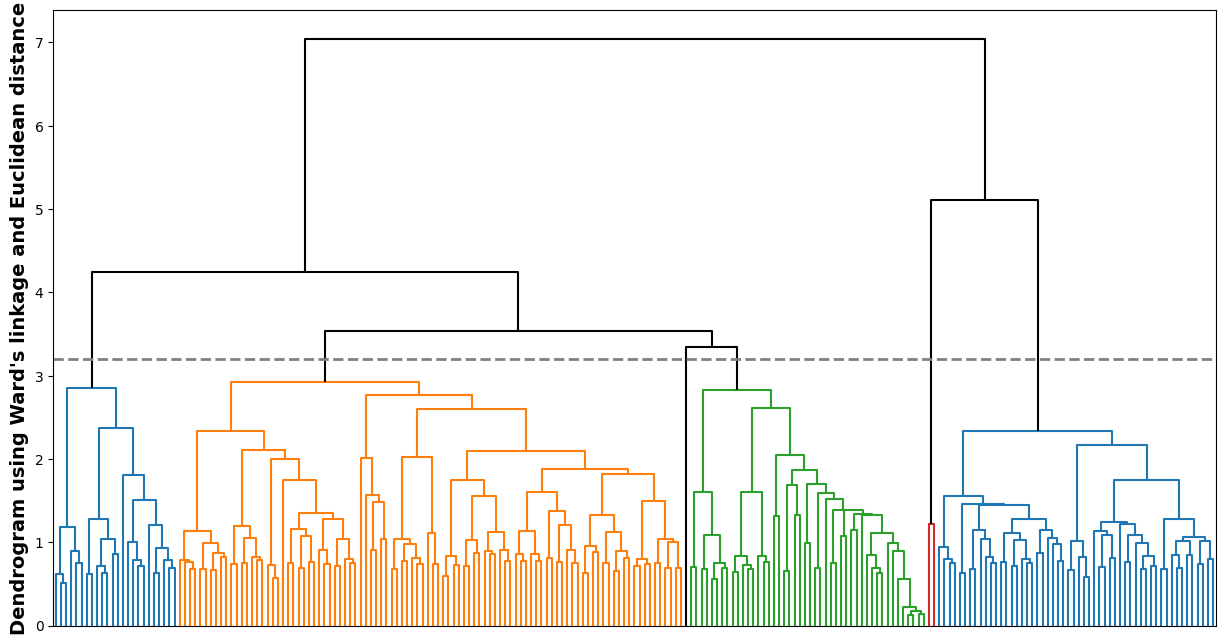

In [37]:
### GENERATE MACRO CLUSTERS (PHENOTYPES) ###

# Set figure size
plt.figure(figsize = (15, 8)) 

# Define the colour scheme for the dendrogram
hierarchy.set_link_color_palette(["#1F77B4", "#FF7F0E", "#2CA02C", "#D62728"])

# Generate and plot the dendrogram
linkage_method = linkage(refvect_df, method ='ward', metric='euclidean')
dendrogram(linkage_method,color_threshold=3.2, above_threshold_color='black')
plt.tick_params(left = True, right = False , labelleft = True , 
                labelbottom = False, bottom = False) 

plt.axhline(3.2, color ="grey", linewidth=2,linestyle ="--")
plt.ylabel("Dendrogram using Ward's linkage and Euclidean distance", fontsize = 14, fontweight="bold")


cluster_ea = AgglomerativeClustering(n_clusters=5, linkage='ward',affinity='euclidean')

clusters = cluster_ea.fit_predict(refvect_df)

classMap_clusters = pd.DataFrame({"x1":gtm_model.matX[:,0],
                                        "x2":gtm_model.matX[:,1],
                                        "Participants in Cluster":H.flatten(),
                                        "Cluster":clusters+1}
                                        )

chart_cluster=alt.Chart(classMap_clusters).mark_circle(size = 450).encode(
    x=alt.X('x1:Q', axis=alt.Axis(labels=False,title = "")),
    y=alt.Y('x2:Q', axis=alt.Axis(labels=False,title = "")),
    size=alt.Size('Participants in Cluster:Q',title = textwrap.wrap('Participants in Cluster',13)),
    color=alt.Color("Cluster:N")
    .scale(range=["#D62728","#2CA02C", "#FF7F0E", "#7F7F7F", "#1F77B4"])
).configure_view(
    continuousHeight=400,
    continuousWidth=400
)

chart_cluster

In [147]:
stroke_definitions = pd.read_csv("D:/UKBiobank/AF_PHENOTYPE_GTM/data/ukbiobank/stroke_definitions.csv")
# 定义要删除的 UID 列值，因为是隐私信息
uids_to_remove = ['22702-0.0', '22704-0.0']

# 删除这些 UID 对应的行
ukbiobank_variable_definitions = ukbiobank_variable_definitions[~ukbiobank_variable_definitions['UDI'].isin(uids_to_remove)]

In [148]:
### CREATE AUTOMATIC SUMMARY TABLE GENERATION ###

### ALL VARS ###

# Identify Integer and Categorical variables as these will need to be displayed differently #

cluster_vars = ukbiobank_variable_definitions.loc[ukbiobank_variable_definitions["exclude_from_naming"]==0]
categorical_vars = cluster_vars.loc[cluster_vars["variable_type"]=="categorical"]
integer_vars = cluster_vars.loc[cluster_vars["variable_type"]=="integer"]

# all_participants_summary_int = pd.DataFrame(columns=["variable_name","field_id","variable_type","mean","lower_95%_CI","upper_95%_CI"])
all_participants_summary_int = pd.DataFrame(columns=["variable_name","field_id","variable_type","median","Q1","Q3"])

# Calculate and store the total number of participants
total_participants = len(memb_map_df_demographics)
all_participants_summary_int.loc[0] = ["Total Participants",np.nan,np.nan,total_participants,np.nan,np.nan]

for i in range(len(integer_vars)):
    
    row = []
    
    # ADD MODELLING VARIABLES FIRST #
    if (integer_vars["field_id_category"].iloc[i] == "Biological Samples") or (integer_vars["field_id_category"].iloc[i] == "Genomics"):
        
        # variable name
        row.append(integer_vars["variable_description"].iloc[i])
        # field id
        row.append(integer_vars["field_id"].iloc[i])
        # variable type
        row.append("Modelling")
        # generate statistics
        
        # median
        row.append(memb_map_df_demographics[integer_vars["UDI"].iloc[i]].quantile([0.5]).iloc[0])
        # Q1
        row.append(memb_map_df_demographics[integer_vars["UDI"].iloc[i]].quantile([0.25]).iloc[0])
        # Q3
        row.append(memb_map_df_demographics[integer_vars["UDI"].iloc[i]].quantile([0.75]).iloc[0])
        
        all_participants_summary_int.loc[i+1]=row
    else:
        # variable name
        row.append(integer_vars["variable_description"].iloc[i])
        # field id
        row.append(integer_vars["field_id"].iloc[i])
        # variable type
        row.append("Visualisation")
        # generate statistics
        
        # median
        row.append(memb_map_df_demographics[integer_vars["variable_description"].iloc[i]].quantile([0.5]).iloc[0])
        # Q1
        row.append(memb_map_df_demographics[integer_vars["variable_description"].iloc[i]].quantile([0.25]).iloc[0])
        # Q3
        row.append(memb_map_df_demographics[integer_vars["variable_description"].iloc[i]].quantile([0.75]).iloc[0])
        
        all_participants_summary_int.loc[i+1]=row
    

In [149]:
### CREATE AUTOMATIC SUMMARY TABLE GENERATION ###

### ALL VARS ###

# Identify Integer and Categorical variables as these will need to be displayed differently #

cluster_vars = ukbiobank_variable_definitions.loc[ukbiobank_variable_definitions["exclude_from_naming"]==0]
categorical_vars = cluster_vars.loc[cluster_vars["variable_type"]=="categorical"]
integer_vars = cluster_vars.loc[cluster_vars["variable_type"]=="integer"]

# all_participants_summary_int = pd.DataFrame(columns=["variable_name","field_id","variable_type","mean","lower_95%_CI","upper_95%_CI"])
all_participants_summary_int = pd.DataFrame(columns=["variable_name","field_id","variable_type","median","Q1","Q3"])

# Calculate and store the total number of participants
total_participants = len(memb_map_df_demographics)
all_participants_summary_int.loc[0] = ["Total Participants",np.nan,np.nan,total_participants,np.nan,np.nan]

for i in range(len(integer_vars)):
    
    row = []
    
    # ADD MODELLING VARIABLES FIRST #
    if (integer_vars["field_id_category"].iloc[i] == "Biological Samples") or (integer_vars["field_id_category"].iloc[i] == "Genomics"):
        
        # variable name
        row.append(integer_vars["variable_description"].iloc[i])
        # field id
        row.append(integer_vars["field_id"].iloc[i])
        # variable type
        row.append("Modelling")
        # generate statistics
        
        # median
        row.append(memb_map_df_demographics[integer_vars["UDI"].iloc[i]].quantile([0.5]).iloc[0])
        # Q1
        row.append(memb_map_df_demographics[integer_vars["UDI"].iloc[i]].quantile([0.25]).iloc[0])
        # Q3
        row.append(memb_map_df_demographics[integer_vars["UDI"].iloc[i]].quantile([0.75]).iloc[0])
        
        all_participants_summary_int.loc[i+1]=row
    else:
        # variable name
        row.append(integer_vars["variable_description"].iloc[i])
        # field id
        row.append(integer_vars["field_id"].iloc[i])
        # variable type
        row.append("Visualisation")
        # generate statistics
        
        # median
        row.append(memb_map_df_demographics[integer_vars["variable_description"].iloc[i]].quantile([0.5]).iloc[0])
        # Q1
        row.append(memb_map_df_demographics[integer_vars["variable_description"].iloc[i]].quantile([0.25]).iloc[0])
        # Q3
        row.append(memb_map_df_demographics[integer_vars["variable_description"].iloc[i]].quantile([0.75]).iloc[0])
        
        all_participants_summary_int.loc[i+1]=row

## uk bio bank categories
all_participants_summary_cat = pd.DataFrame(columns=["variable_name","field_id","variable_type","count","percentage"])
all_participants_summary_cat.loc[0] = ["Total Participants",np.nan,np.nan,total_participants,np.nan]

for j in range(len(categorical_vars)):
    
    row = []
    
    row.append(categorical_vars["variable_description"].iloc[j])
    # field id
    row.append(categorical_vars["field_id"].iloc[j])
    # variable type
    row.append("Visualisation")
    # count 
    row.append(pd.to_numeric(memb_map_df_demographics[categorical_vars["variable_description"].iloc[j]]).sum())
    # percentage
    row.append(np.round((pd.to_numeric(memb_map_df_demographics[categorical_vars["variable_description"].iloc[j]]).sum()/total_participants)*100,2))
       
    all_participants_summary_cat.loc[j+1]=row

# diagnosis categories
for j in range(len(stroke_definitions)):
    row = []
    
    row.append(stroke_definitions["fi_vl_text"].iloc[j])
    # field id
    row.append(stroke_definitions["field_id"].iloc[j])
    # variable type
    row.append("Visualisation")
    # count 
    row.append(memb_map_df_demographics[stroke_definitions["fi_vl_text"].iloc[j]].sum())
    # percentage
    row.append(np.round((memb_map_df_demographics[stroke_definitions["fi_vl_text"].iloc[j]].sum()/total_participants)*100,2))
    
    if memb_map_df_demographics[stroke_definitions["fi_vl_text"].iloc[j]].sum() > 0:
        new_pos = len(all_participants_summary_cat)
    
        all_participants_summary_cat.loc[new_pos]=row

# Phecode categories

# Convert data show it shows just one value per participant
phecode_cat_data_updated = phecode_cat_data.drop("eid",axis=1)
phecode_cat_data_updated[phecode_cat_data_updated>1] = 1
phecode_cat_data_updated.reset_index()
phecode_cat_data_updated = pd.concat([phecode_cat_data["eid"], phecode_cat_data_updated], axis=1)

for j in range(1,len(phecode_cat_data_updated.columns)):
    row = []
    
    row.append(phecode_cat_data_updated.columns[j])
    # field id
    row.append(np.nan)
    # variable type
    row.append("Visualisation")
    # count  
    row.append(phecode_cat_data_updated[phecode_cat_data_updated.columns[j]].sum())
    # percentage
    row.append(np.round((phecode_cat_data_updated[phecode_cat_data_updated.columns[j]].sum()/total_participants)*100,2))
    
    new_pos = len(all_participants_summary_cat)
    
    all_participants_summary_cat.loc[new_pos]=row

# Phecodes

# Convert data show it shows just one value per participant
phecode_data_updated = phecode_data.drop("eid",axis=1)
phecode_data_updated[phecode_data_updated>1] = 1
phecode_data_updated.reset_index()
phecode_data_updated = pd.concat([phecode_data["eid"], phecode_data_updated], axis=1)

for j in range(1,len(phecode_data_updated.columns)):
    row = []
    
    row.append(phecode_data_updated.columns[j])
    # field id
    row.append(np.nan)
    # variable type
    row.append("Visualisation")
    # count  
    row.append(phecode_data_updated[phecode_data_updated.columns[j]].sum())
    # percentage
    row.append(np.round((phecode_data_updated[phecode_data_updated.columns[j]].sum()/total_participants)*100,2))
    
    new_pos = len(all_participants_summary_cat)
    
    all_participants_summary_cat.loc[new_pos]=row

In [152]:
### DEMONSTRATE THE SUMMARY DATAFRAME FOR THE INT VARIABLES ###
all_participants_summary_int.head(10)

,variable_name,field_id,variable_type,median,Q1,Q3
0,Total Participants,NaN,NaN,12674.0,NaN,NaN
1,Waist circumference,48.0,Visualisation,94.0,85.0,102.0
2,Hip circumference,49.0,Visualisation,103.0,98.0,109.0
3,Standing height,50.0,Visualisation,169.0,162.0,175.0
4,"Pulse rate, automated reading",102.0,Visualisation,69.0,61.0,78.0
5,Number of self-reported cancers,134.0,Visualisation,0.0,0.0,0.0
6,Number of treatments/medications taken,137.0,Visualisation,3.0,1.0,5.0
7,Length of time at current address,699.0,Visualisation,20.0,8.0,30.0
8,Number of days/week walked 10+ minutes,864.0,Visualisation,6.0,4.0,7.0
9,Time spent using computer,1080.0,Visualisation,0.0,0.0,1.0


In [153]:
### DEMONSTRATE THE SUMMARY DATAFRAME FOR THE CATEGORICAL VARIABLES ###
all_participants_summary_cat.head(10)

,variable_name,field_id,variable_type,count,percentage
0,Total Participants,NaN,NaN,12674.0,NaN
1,Sex,31.0,Visualisation,7150.0,56.41
2,Job involves mainly walking or standing - Neve...,806.0,Visualisation,1479.0,11.67
3,Job involves mainly walking or standing - Some...,806.0,Visualisation,1442.0,11.38
4,Job involves mainly walking or standing - Usually,806.0,Visualisation,744.0,5.87
5,Job involves mainly walking or standing - Always,806.0,Visualisation,1119.0,8.83
6,Job involves heavy manual or physical work - N...,816.0,Visualisation,2829.0,22.32
7,Job involves heavy manual or physical work - S...,816.0,Visualisation,1159.0,9.14
8,Job involves heavy manual or physical work - U...,816.0,Visualisation,396.0,3.12
9,Job involves heavy manual or physical work - A...,816.0,Visualisation,397.0,3.13


In [154]:
classMap_clusters = pd.DataFrame({"x1":gtm_model.matX[:,0],
                                        "x2":gtm_model.matX[:,1],
                                        "Participants in Cluster":H.flatten(),
                                        "Cluster":clusters+1}
                                        )


In [155]:
### CREATE AUTOMATIC SUMMARY TABLE GENERATION ###

from scipy.stats import kruskal

### CLUSTERS ###
## Assign macro clusters to their respective participants

memb_map_df_demographics = memb_map_df_demographics.merge(classMap_clusters[["x1","x2","Cluster"]], how="inner",left_on = ["x1_modes","x2_modes"],right_on=["x1","x2"])

# Identify Integer and Categorical variables as these will need to be displayed differently #
cluster_vars = ukbiobank_variable_definitions.loc[ukbiobank_variable_definitions["exclude_from_naming"]==0]
integer_vars = cluster_vars.loc[cluster_vars["variable_type"]=="integer"]
categorical_vars = cluster_vars.loc[cluster_vars["variable_type"]=="categorical"]

# Calculate integer variable summaries


cluster_summary_int=pd.DataFrame(columns=["variable_name","field_id","variable_type","median - cluster 1","Q1 - cluster 1","Q3 - cluster 1"
                                                                                    ,"median - cluster 2","Q1 - cluster 2","Q3 - cluster 2"
                                                                                    ,"median - cluster 3","Q1 - cluster 3","Q3 - cluster 3"
                                                                                    ,"median - cluster 4","Q1 - cluster 4","Q3 - cluster 4"
                                                                                    ,"median - cluster 5","Q1 - cluster 5","Q3 - cluster 5"
                                                                                    ,"P Value"])

# Initiate the total participant row
cluster_summary_int.loc[0] = ["Total Participants",np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]

for i in range(len(integer_vars)):
    row = []

    # variable name
    row.append(integer_vars["variable_description"].iloc[i])
    # field id
    row.append(integer_vars["field_id"].iloc[i])
    
    if (integer_vars["field_id_category"].iloc[i] == "Biological Samples") or (integer_vars["field_id_category"].iloc[i] == "Genomics"):
        # variable type
        row.append("Modelling")
    else:
        # variable type
        row.append("Visualisation")
        
    for mc in range(5):
        
        ## Calcualte all values for the ith cluster
        
        # Calculate and store the total number of participants
        total_participants = len(memb_map_df_demographics.loc[memb_map_df_demographics["Cluster"] == (mc+1)])
        cluster_summary_int["median - cluster "+str(mc+1)].iloc[0] = total_participants
        
        participants_in_cluster = memb_map_df_demographics.loc[memb_map_df_demographics["Cluster"] == (mc+1)]
        
        
        # ADD MODELLING VARIABLES FIRST #
        if (integer_vars["field_id_category"].iloc[i] == "Biological Samples") or (integer_vars["field_id_category"].iloc[i] == "Genomics"):
            
            # generate statistics
            
            # median
            row.append(participants_in_cluster[integer_vars["UDI"].iloc[i]].quantile([0.5]).iloc[0])
            # Q1
            row.append(participants_in_cluster[integer_vars["UDI"].iloc[i]].quantile([0.25]).iloc[0])
            # Q3
            row.append(participants_in_cluster[integer_vars["UDI"].iloc[i]].quantile([0.75]).iloc[0])
            
        else:
            
            # generate statistics
            
            # median
            row.append(participants_in_cluster[integer_vars["variable_description"].iloc[i]].quantile([0.5]).iloc[0])
            # Q1
            row.append(participants_in_cluster[integer_vars["variable_description"].iloc[i]].quantile([0.25]).iloc[0])
            # Q3
            row.append(participants_in_cluster[integer_vars["variable_description"].iloc[i]].quantile([0.75]).iloc[0])
    
    if (integer_vars["field_id_category"].iloc[i] == "Biological Samples") or (integer_vars["field_id_category"].iloc[i] == "Genomics"):
        
        column = integer_vars["UDI"].iloc[i]
        
        column_data = memb_map_df_demographics[[column,"Cluster"]]
        column_data_cluster_1 = column_data[column].loc[column_data["Cluster"]==1].dropna().values
        column_data_cluster_2 = column_data[column].loc[column_data["Cluster"]==2].dropna().values
        column_data_cluster_3 = column_data[column].loc[column_data["Cluster"]==3].dropna().values
        column_data_cluster_4 = column_data[column].loc[column_data["Cluster"]==4].dropna().values
        column_data_cluster_5 = column_data[column].loc[column_data["Cluster"]==5].dropna().values
        H_statistic, p_value = kruskal(column_data_cluster_1,column_data_cluster_2,column_data_cluster_3,column_data_cluster_4,column_data_cluster_5)
        
    else:
        
        column = integer_vars["variable_description"].iloc[i]
        
        column_data = memb_map_df_demographics[[column,"Cluster"]]
        column_data_cluster_1 = column_data[column].loc[column_data["Cluster"]==1].dropna().values
        column_data_cluster_2 = column_data[column].loc[column_data["Cluster"]==2].dropna().values
        column_data_cluster_3 = column_data[column].loc[column_data["Cluster"]==3].dropna().values
        column_data_cluster_4 = column_data[column].loc[column_data["Cluster"]==4].dropna().values
        column_data_cluster_5 = column_data[column].loc[column_data["Cluster"]==5].dropna().values
        H_statistic, p_value = kruskal(column_data_cluster_1,column_data_cluster_2,column_data_cluster_3,column_data_cluster_4,column_data_cluster_5)
    
    
    row.append(p_value)
    cluster_summary_int.loc[i+1]=row


In [157]:

# ## uk bio bank categories

cluster_summary_cat = pd.DataFrame(columns=["variable_name","field_id","variable_type","count - cluster 1","percentage - cluster 1"
                                                                                                ,"count - cluster 2","percentage - cluster 2"
                                                                                                ,"count - cluster 3","percentage - cluster 3"
                                                                                                ,"count - cluster 4","percentage - cluster 4"
                                                                                                ,"count - cluster 5","percentage - cluster 5"
                                                                                                ,"P Value"])

cluster_summary_cat.loc[0] = ["Total Participants",np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]

for j in range(len(categorical_vars)):
    
    row = []
    
    row.append(categorical_vars["variable_description"].iloc[j])
    # field id
    row.append(categorical_vars["field_id"].iloc[j])
    # variable type
    row.append("Visualisation")
    
    for mc in range(5):
        ## Calcualte all values for the ith cluster
        
        # Calculate and store the total number of participants
        total_participants = len(memb_map_df_demographics.loc[memb_map_df_demographics["Cluster"] == (mc+1)])
        cluster_summary_cat["count - cluster "+str(mc+1)].iloc[0] = total_participants
        
        participants_in_cluster = memb_map_df_demographics.loc[memb_map_df_demographics["Cluster"] == (mc+1)]
        
        # count 
        row.append(pd.to_numeric(participants_in_cluster[categorical_vars["variable_description"].iloc[j]]).sum())
        # percentage
        row.append(np.round((pd.to_numeric(participants_in_cluster[categorical_vars["variable_description"].iloc[j]]).sum()/total_participants)*100,2))
    row.append(np.nan)
    cluster_summary_cat.loc[j+1]=row
test = []
# # diagnosis categories
for j in range(len(stroke_definitions)):
    row = []
    
    row.append(stroke_definitions["fi_vl_text"].iloc[j])
    # field id
    row.append(stroke_definitions["field_id"].iloc[j])
    # variable type
    row.append("Visualisation")
    
    for mc in range(5):
        
        ## Calcualte all values for the ith cluster
        
        # Calculate and store the total number of participants
        total_participants = len(memb_map_df_demographics.loc[memb_map_df_demographics["Cluster"] == (mc+1)])
        cluster_summary_cat["count - cluster "+str(mc+1)].iloc[0] = total_participants
        
        participants_in_cluster = memb_map_df_demographics.loc[memb_map_df_demographics["Cluster"] == (mc+1)]
        
        # count 
        row.append(participants_in_cluster[stroke_definitions["fi_vl_text"].iloc[j]].sum())
        # percentage
        row.append(np.round((participants_in_cluster[stroke_definitions["fi_vl_text"].iloc[j]].sum()/total_participants)*100,2))
    
    new_pos = len(cluster_summary_cat)
    row.append(np.nan)
    test.append(row)
    cluster_summary_cat.loc[new_pos]=row


In [158]:
# # Phecode categories

# Convert data show it shows just one value per participant
phecode_cat_data_updated = phecode_cat_data.drop("eid",axis=1)
phecode_cat_data_updated[phecode_cat_data_updated>1] = 1
phecode_cat_data_updated.reset_index()
phecode_cat_data_updated = pd.concat([phecode_cat_data["eid"], phecode_cat_data_updated], axis=1)
phecode_cat_data_updated = phecode_cat_data_updated.merge(memb_map_df_demographics[["eid","Cluster"]],how="inner",left_on="eid",right_on="eid")

for j in range(1,len(phecode_cat_data_updated.columns)-1):
    row = []
    
    row.append(phecode_cat_data_updated.columns[j])
    # field id
    row.append(np.nan)
    # variable type
    row.append("Visualisation")
    
    for mc in range(5):
        
        ## Calcualte all values for the ith cluster
        
        participants_in_cluster = phecode_cat_data_updated.loc[phecode_cat_data_updated["Cluster"] == (mc+1)]
        # Calculate and store the total number of participants
        total_participants = len(participants_in_cluster.loc[participants_in_cluster["Cluster"] == (mc+1)])
        cluster_summary_cat["count - cluster "+str(mc+1)].iloc[0] = total_participants
        
        # count  
        row.append(participants_in_cluster[phecode_cat_data_updated.columns[j]].sum())
        # percentage
        row.append(np.round((participants_in_cluster[phecode_cat_data_updated.columns[j]].sum()/total_participants)*100,2))
        
    new_pos = len(cluster_summary_cat)
    row.append(np.nan)
    cluster_summary_cat.loc[new_pos]=row

# # Phecodes

# Convert data show it shows just one value per participant
phecode_data_updated = phecode_data.drop("eid",axis=1)
phecode_data_updated[phecode_data_updated>1] = 1
phecode_data_updated.reset_index()
phecode_data_updated = pd.concat([phecode_data["eid"], phecode_data_updated], axis=1)
phecode_data_updated = phecode_data_updated.merge(memb_map_df_demographics[["eid","Cluster"]],how="inner",left_on="eid",right_on="eid")

for j in range(1,len(phecode_data_updated.columns)-1):
    row = []
    
    row.append(phecode_data_updated.columns[j])
    # field id
    row.append(np.nan)
    # variable type
    row.append("Visualisation")
    
    for mc in range(5):
        
        ## Calcualte all values for the ith cluster
        
        participants_in_cluster = phecode_data_updated.loc[phecode_data_updated["Cluster"] == (mc+1)]
        # Calculate and store the total number of participants
        total_participants = len(participants_in_cluster.loc[participants_in_cluster["Cluster"] == (mc+1)])
        cluster_summary_cat["count - cluster "+str(mc+1)].iloc[0] = total_participants
        

        # count  
        row.append(participants_in_cluster[phecode_data_updated.columns[j]].sum())
        # percentage
        row.append(np.round((participants_in_cluster[phecode_data_updated.columns[j]].sum()/total_participants)*100,2))
        
    new_pos = len(cluster_summary_cat)
    row.append(np.nan)
    cluster_summary_cat.loc[new_pos]=row

In [161]:
cluster_summary_cat

,variable_name,field_id,variable_type,count - cluster 1,percentage - cluster 1,count - cluster 2,percentage - cluster 2,count - cluster 3,percentage - cluster 3,count - cluster 4,percentage - cluster 4,count - cluster 5,percentage - cluster 5,P Value
0,Total Participants,NaN,NaN,5067.0,NaN,3218.0,NaN,3685.0,NaN,59.0,NaN,645.0,NaN,NaN
1,Sex,31.0,Visualisation,4466.0,88.14,303.0,9.42,1979.0,53.70,36.0,61.02,366.0,56.74,0.000000e+00
2,Job involves mainly walking or standing - Neve...,806.0,Visualisation,621.0,12.26,375.0,11.65,383.0,10.39,9.0,15.25,91.0,14.11,3.181341e-02
3,Job involves mainly walking or standing - Some...,806.0,Visualisation,656.0,12.95,294.0,9.14,400.0,10.85,10.0,16.95,82.0,12.71,9.084065e-06
4,Job involves mainly walking or standing - Usually,806.0,Visualisation,331.0,6.53,164.0,5.10,209.0,5.67,4.0,6.78,36.0,5.58,1.121088e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,Type 2 diabetes with ophthalmic manifestations,NaN,Visualisation,89.0,1.76,25.0,0.78,290.0,7.87,2.0,3.39,7.0,1.09,1.482893e-73
201,Type 2 diabetes with renal manifestations,NaN,Visualisation,17.0,0.34,4.0,0.12,93.0,2.52,0.0,0.00,1.0,0.16,1.460090e-31
202,Unspecified diffuse connective tissue disease,NaN,Visualisation,3.0,0.06,13.0,0.40,7.0,0.19,0.0,0.00,0.0,0.00,6.552025e-03
203,Vascular dementia,NaN,Visualisation,191.0,3.77,89.0,2.77,179.0,4.86,4.0,6.78,24.0,3.72,3.151016e-04


In [159]:
expected_ratios = cluster_summary_cat[["count - cluster 1","count - cluster 2","count - cluster 3","count - cluster 4",
                                    "count - cluster 5"]].iloc[0].values
expected_ratios = expected_ratios / np.sum(expected_ratios)

for i in range(1,len(cluster_summary_cat)):
    observed = cluster_summary_cat[["count - cluster 1","count - cluster 2","count - cluster 3","count - cluster 4",
                                    "count - cluster 5"]].iloc[i].values.astype(int)
    observed_sum = np.sum(observed)

    expected = expected_ratios * observed_sum

    # perform chi-square test
    chi2, p = chisquare(observed, f_exp=expected)
    
    cluster_summary_cat["P Value"].iloc[i] = p

E:\Users\admin\miniconda3\envs\GTM\lib\site-packages\scipy\stats\_stats_py.py:7166: RuntimeWarning: invalid value encountered in divide
  terms = (f_obs_float - f_exp)**2 / f_exp
E:\Users\admin\miniconda3\envs\GTM\lib\site-packages\scipy\stats\_stats_py.py:7166: RuntimeWarning: invalid value encountered in divide
  terms = (f_obs_float - f_exp)**2 / f_exp
E:\Users\admin\miniconda3\envs\GTM\lib\site-packages\scipy\stats\_stats_py.py:7166: RuntimeWarning: invalid value encountered in divide
  terms = (f_obs_float - f_exp)**2 / f_exp


In [160]:
### GENERATE PROBABLITY DISTRIBUTION PLOTS ###


i = np.random.randint(len(memb_map_df))


classMap_prob = classMap.copy()
classMap_prob["prob"] = gtm_model.matR[i,:]

prob_map_orig=alt.Chart(classMap_prob).mark_circle(size = 350).encode(
                                                    x=alt.X('x1:Q', axis=alt.Axis(labels=False,title = "")),
                                                    y=alt.Y('x2:Q', axis=alt.Axis(labels=False,title = "")),
                                                    # size=30,
                                                    color=alt.Color('prob:Q',
                                                                    scale=alt.Scale(scheme='viridis'),
                                                                    title=textwrap.wrap("",20))
                                                ).configure_view(
                                                    continuousHeight=400,
                                                    continuousWidth=400
                                                )

prob_map_orig


alt.Chart(...)